In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo

In [3]:
class LeakyIntegrator(nengo.LIF):
    threshold = nengo.params.NumberParam('threshold')
    
    def __init__(self, amplitude=1, threshold=0, tau_rc=0.02, min_voltage=0):
        super().__init__(amplitude=amplitude, tau_rc=tau_rc, tau_ref=0, min_voltage=min_voltage)
        self.threshold = threshold
        
    def step_math(self, dt, J, output, voltage, refractory_time):
        output[:] = np.where(voltage>self.threshold, voltage, 0)
        
        dv = -voltage + output + J
        
        voltage += dv*(dt/self.tau_rc)
        
        voltage[voltage < self.min_voltage] = self.min_voltage

In [40]:
N = 10
J = 20
seed = 1
np.random.seed(seed=seed)
span = np.linspace(0, 1, N)
image = (np.sin(2*np.pi*span)+1)/2

class AdaptiveWeights(object):
    def __init__(self, w, learning_rate):
        self.w = w
        self.learning_rate = learning_rate
        self.pre_value = np.zeros(self.w.shape[1])
        self.post_value = np.zeros(self.w.shape[0])
        
    def make_forward_node(self):
        return nengo.Node(self.update_forward, size_in=w.shape[1], size_out=w.shape[0])
    def make_reverse_node(self):
        return nengo.Node(self.update_reverse, size_in=w.shape[0], size_out=w.shape[1])
    
    def update_forward(self, t, x):
        self.pre_value[:] = x
        return np.dot(self.w, x)
    
    
    
    def update_reverse(self, t, x):
        self.post_value[:] = x
        
        self.w += self.learning_rate * np.outer(self.post_value, self.pre_value)
        
        return np.dot(-self.w.T, x)
        


model = nengo.Network(seed=seed)
with model:
    stim = nengo.Node(image)
    
    residual = nengo.Node(None, size_in=N)
    
    v1 = nengo.Ensemble(n_neurons=J, dimensions=1,
                          neuron_type=LeakyIntegrator(threshold=0.1, tau_rc=0.001),
                          gain=nengo.dists.Choice([1]),
                          bias=nengo.dists.Choice([0]))
        
    w = np.random.uniform(-0.1, 0.1, (J, N))
    adapt = AdaptiveWeights(w, learning_rate=1e-4)
    fwd_node = adapt.make_forward_node()
    rev_node = adapt.make_reverse_node()
    
    
    tau = 0
    nengo.Connection(residual, fwd_node, synapse=tau)
    nengo.Connection(fwd_node, v1.neurons, synapse=None)
        
    nengo.Connection(stim, residual, synapse=0)
    nengo.Connection(v1.neurons, rev_node, synapse=tau)
    nengo.Connection(rev_node, residual, synapse=None)
    
    p_v1 = nengo.Probe(v1.neurons)
    p_res = nengo.Probe(residual)
    
    
sim = nengo.Simulator(model)
sim.run(0.5)
                        

c:\users\terry\documents\github\nengo\nengo\neurons.py:436: RuntimeWarning: divide by zero encountered in log1p
  1.0 / (gain * (intercepts - 1) - 1)))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

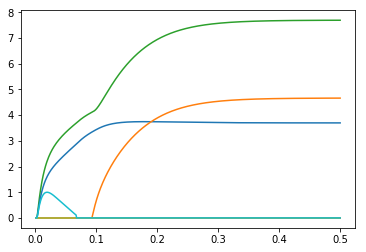

In [41]:
plt.plot(sim.trange(), sim.data[p_v1])
plt.show()

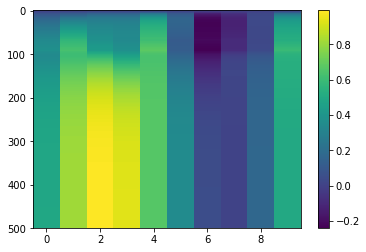

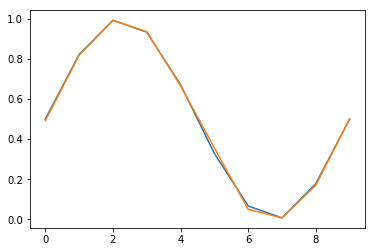

In [42]:
recon = np.dot(sim.data[p_v1], w)
plt.imshow(recon, aspect='auto')
plt.colorbar()
plt.figure()
plt.plot(image)
plt.plot(recon[-1])

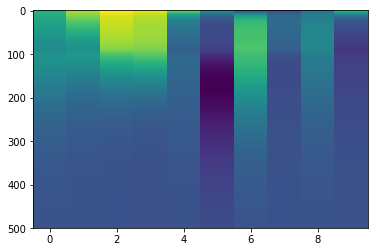

In [38]:
plt.imshow(sim.data[p_res][:,:], aspect='auto')

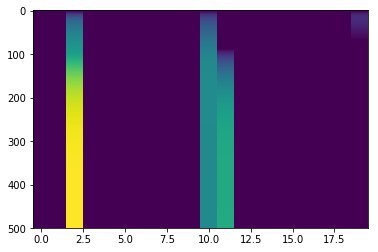

In [39]:
plt.imshow(sim.data[p_v1], aspect='auto')